In [1]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import numpy as np

In [9]:
# Load the data
with open('data/shell_comparison_RAL_with_prm3.json') as f:
    data = json.load(f)

# Flatten the data and load it into a pandas DataFrame
df = pd.json_normalize(data)

# Rename the columns to remove the dots
df.columns = df.columns.str.split('.').str[-1]

# Calculate n_visited/n_total
df['visit_ratio'] = df['n_visited'] / df['n_total']

# Get the maximum visit_ratio for each scene
max_visit_ratio = df.groupby('scene')['visit_ratio'].transform('max')

# Create a new column to indicate if the visit_ratio is below 0.95 times the maximum for that scene
df['low_visit_ratio'] = df['visit_ratio'] < 0.95 * max_visit_ratio

df['length_per_visited'] = df['total_path_length'] / df['n_visited']

In [34]:
def get_planner_name(planner, shell_type):
    """
    Given a planner and shell type, return a user-friendly planner name.
    
    Args:
        planner (str): The name of the planner.
        shell_type (str): The type of shell.
        
    Returns:
        str: A user-friendly planner name.
    """
    if planner == 'shell_based':
        if shell_type == 'minimum_enclosing_sphere':
            return 'Sphere Shell'
        elif shell_type == 'cgal_convex_hull':
            return 'Convex Hull Shell'
    elif planner == 'tsp_over_prm*':
        return 'TSPoPRM*'
    return None


def plot_scene_data(ax, scene_runs, color_map, low_color_map, handles, labels):
    """
    Plot the scene data on the given axis.
    
    Args:
        ax (matplotlib.axis): The axis to plot the data on.
        scene_runs (DataFrame): The data for the scene.
        color_map (dict): Mapping of planner names to colors.
        low_color_map (dict): Mapping of planner names to low ratio colors.
        handles (list): List to store handles for the legend.
        labels (list): List to store labels for the legend.
    """
    # Iterate through the groups of data defined by planner and shell type
    for ((planner, st), runs) in scene_runs.groupby(['name', 'shell_type'], dropna=False):
        
        # Get the user-friendly planner name
        name = get_planner_name(planner, st)
        if not name:
            continue
        
        # Select color based on the planner name
        color = color_map[name]
        
        # Split data based on visit_ratio
        low_ratio_data = runs[runs['low_visit_ratio']]
        high_ratio_data = runs[~runs['low_visit_ratio']]
        
        # Plot the high ratio data
        h1 = ax.scatter(high_ratio_data['time'], high_ratio_data['length_per_visited'], color=color)
        
        # Store handle and label for legend if not already stored
        if name not in labels:
            handles.append(h1)
            labels.append(name)
            
        # Plot the low ratio data if present
        low_color = low_color_map[name]
        h2 = ax.scatter(low_ratio_data['time'], low_ratio_data['length_per_visited'], color=low_color, marker='x', alpha=0.5)

        # Store handle and label for legend if not already stored
        if f'{name} (lv)' not in labels:
            handles.append(h2)
            labels.append(f'{name} (lv)')


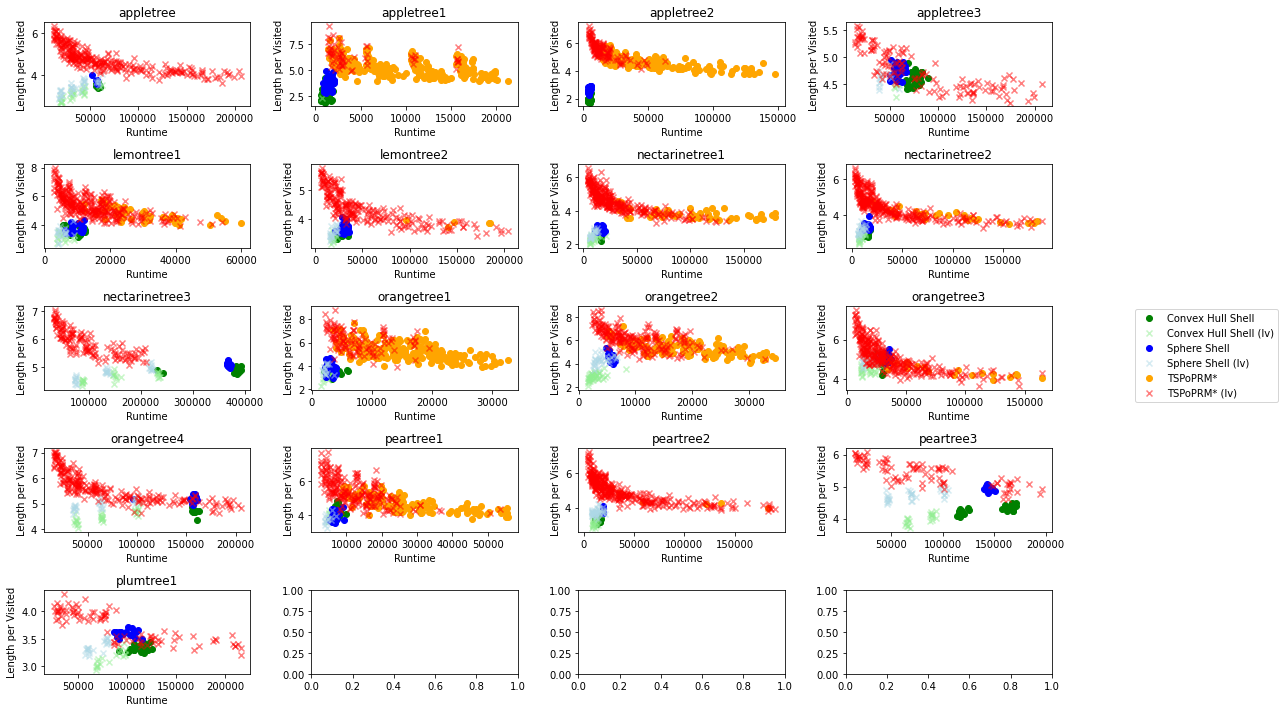

In [35]:
# Calculate the new metric
df['length_per_visited'] = df['total_path_length'] / df['n_visited']

# Create a color map for the planner names and shell types
unique_names = ['Sphere Shell', 'Convex Hull Shell', 'TSPoPRM*']
colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_names)))
color_map = {
    'Sphere Shell': 'blue', 
    'Convex Hull Shell': 'green', 
    'TSPoPRM*': 'orange'
}

# Create a color map for low visit ratio data points
low_colors = plt.cm.autumn(np.linspace(0, 1, len(unique_names)))
low_color_map = {
    'Sphere Shell': 'lightblue', 
    'Convex Hull Shell': 'lightgreen', 
    'TSPoPRM*': 'red'
}

# Create a grid of scatterplots
fig, axs = plt.subplots(5, 4, figsize=(15, 10))

# Keep track of handles and labels for the legend
handles, labels = [], []

grouped_scene = df.groupby('scene')

# Loop through each subplot and scene data
for ax, (scene, scene_runs) in zip(axs.flatten(), grouped_scene):
    
    # Plot data for this scene
    plot_scene_data(ax, scene_runs, color_map, low_color_map, handles, labels)
    
    # Set title and labels for this subplot
    ax.set_title(scene)
    ax.set_xlabel('Runtime')
    ax.set_ylabel('Length per Visited')

# Add legend outside of subplots
fig.legend(handles, labels, bbox_to_anchor=(1.05, 0.5), loc='center left')

# Tight layout
plt.tight_layout()

# Show plot
plt.show()
